# Quantitative evaluation

Use ArFace metric and Emotion metric to compare the performance of : 
    - e4e initialization vs hybrid initialization
    - og loss vs custom loss

In [1]:
from argparse import Namespace
import time
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.amp import autocast
from tqdm import tqdm
import clip

from utils.common import tensor2im
from utils.alignment import run_alignment
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.
from criteria.clip_loss import CLIPLoss
from criteria.id_loss import IDLoss

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
RESIZE_DIMS = (256, 256)

In [2]:
# Define the arguments for the e4e encoder

pretrained_pSp_path = 'pretrained_models/e4e_ffhq_encode.pt'

e4e_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

In [3]:
# Load the pSp model

ckpt = torch.load(pretrained_pSp_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = pretrained_pSp_path
opts['ir_se50_weights'] = 'pretrained_models/model_ir_se50.pth'
opts= Namespace(**opts)
latent_avg = ckpt["latent_avg"]

psp_model = pSp(opts)
psp_model.eval()
psp_model.cuda()

print('Model successfully loaded!')

/tmp/ipykernel_295875/3793385928.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrained_pSp_path, map_location='cpu')


Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt


/users/eleves-b/2022/rodrigue.reibel/emotion_generation/models/psp.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.opts.checkpoint_path, map_loca

Model successfully loaded!


In [4]:
import os

input_images_path = "faces_dataset_very_small"
N_images = 10
images = np.array(os.listdir(input_images_path))[np.random.randint(0, len(os.listdir(input_images_path)), N_images)]


In [5]:
# Parameters for inversion
optimization_steps_inv = 50
lambda_percept_inv = 1
lambda_L2_inv = 0.5
lr_inv = 0.01 
final_lr_inv = 0.001

# Parameters for editing
optimization_steps_edit = 50
lambda_L2_edit = 0.008
lambda_ID_edit = 0.005
lr_edit = 0.01
final_lr_edit = 0.001
truncation_edit = 0.9

id_loss = IDLoss(opts)
L2_loss = torch.nn.MSELoss().to(device)
clip_loss = CLIPLoss(opts)

G = psp_model.decoder
prompt = "A happy face"

Loading ResNet ArcFace


/users/eleves-b/2022/rodrigue.reibel/emotion_generation/criteria/id_loss.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.facenet.load_state_dict(torch.load(opts.ir

In [ ]:
sims_e4e = []
sims_hybrid = []
sims_e4e_edit = []
sims_hybrid_edit = []
emo_scores_e4e = []
emo_scores_hybrid = []

for i_image, image_path in enumerate(images):
    print(f"*** Processing image {i_image + 1}/{N_images} ***")
    image = run_alignment(os.path.join(input_images_path, image_path)).resize(RESIZE_DIMS)
    input_image = e4e_transform(image)
    reference_image = transforms.Resize((1024, 1024))(input_image).unsqueeze(0).cuda()


    with torch.no_grad():
        e4e_inverted_latent = psp_model.encoder(input_image.unsqueeze(0).to(device))
    if psp_model.opts.start_from_latent_avg:
                    if e4e_inverted_latent.ndim == 2:
                        e4e_inverted_latent = e4e_inverted_latent + psp_model.latent_avg.repeat(e4e_inverted_latent.shape[0], 1, 1)[:, 0, :]
                    else:
                        e4e_inverted_latent = e4e_inverted_latent + psp_model.latent_avg.repeat(e4e_inverted_latent.shape[0], 1, 1)


    w_n = e4e_inverted_latent.clone().detach().requires_grad_(True).to(device) # initialization with e4e output

    optimizer = torch.optim.Adam([w_n], lr=lr_inv)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=optimization_steps_inv, eta_min=final_lr_inv)

 

    pbar = tqdm(range(optimization_steps_inv))

    imgs = []
    losses = []


    for i in pbar:

        with autocast("cuda"):
            
            optimizer.zero_grad()

            img_gen, _ = G([w_n], input_is_latent=True, randomize_noise=False)

            i_loss = id_loss(img_gen, reference_image)[0]
            l2_loss = L2_loss(img_gen, reference_image)

            loss = i_loss * lambda_percept_inv + l2_loss * lambda_L2_inv 
            losses.append(loss.item())
            pbar.set_description(f"Loss: {loss.item():.4f}")

            loss.backward()
            optimizer.step()
            scheduler.step()

    inverted_latent = w_n.detach()

    # Compute ID metric between inverted images and original image

    with torch.no_grad():
        e4e_inverted_image, _ = G([e4e_inverted_latent], input_is_latent=True, randomize_noise=False)
        inverted_image = img_gen.detach()

    sim_e4e = id_loss(e4e_inverted_image, reference_image)[0]
    sim_hybrid = id_loss(inverted_image, reference_image)[0]

    sims_e4e.append(sim_e4e.item())
    sims_hybrid.append(sim_hybrid.item())

    ##### Editing evaluation #####

    text_inputs = torch.cat([clip.tokenize(prompt)]).cuda()

    for latent, sims, emo_scores in zip([e4e_inverted_latent, inverted_latent], [sims_e4e_edit, sims_hybrid_edit], [emo_scores_e4e, emo_scores_hybrid]):

    # Initialization
        w_start = latent

        w_n = w_start.clone().detach().requires_grad_(True).to(device)
        optimizer = torch.optim.Adam([w_n], lr=lr_edit)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=optimization_steps_edit, eta_min=final_lr_edit)


        with torch.no_grad():
            img_orig, _ = G([w_n], input_is_latent=True)

        pbar = tqdm(range(optimization_steps_edit))

        imgs = []
        losses = []

        # Optimization loop

        for i in pbar:

            with autocast("cuda"):
                
                optimizer.zero_grad()

                img_gen, _ = G([w_n], input_is_latent=True, randomize_noise=False)

                c_loss = clip_loss(img_gen, text_inputs)
                i_loss = id_loss(img_gen, img_orig)[0] # original
                l2_loss = ((w_start - w_n) ** 2).sum()

                loss = c_loss + lambda_L2_edit * l2_loss + lambda_ID_edit * i_loss
                losses.append(loss.item())
                pbar.set_description(f"Loss: {loss.item():.4f}")

                loss.backward()
                optimizer.step()
                scheduler.step()

        final_image = img_gen.detach()

        # Compute ID metric between edited images and original image

        sim = id_loss(final_image, reference_image)[0]
        emo_score = None # TODO: compute emotion score

        sims.append(sim.item())
        emo_scores.append(emo_score.item())

*** Processing image 1/10 ***


Loss: 0.7578: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


*** Processing image 2/10 ***


Loss: 0.7534: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


*** Processing image 3/10 ***


Loss: 0.7764: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


*** Processing image 4/10 ***


Loss: 0.7500: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


*** Processing image 5/10 ***


Loss: 0.7583: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


*** Processing image 6/10 ***


Loss: 0.7646: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


*** Processing image 7/10 ***


Loss: 0.7500: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


*** Processing image 8/10 ***


Loss: 0.7598: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


*** Processing image 9/10 ***


Loss: 0.7974: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


*** Processing image 10/10 ***


Loss: 0.7559: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


In [8]:
# Save results

save_path = "results"
os.makedirs(save_path, exist_ok=True)

SAVE_RESULTS = False

if SAVE_RESULTS:
    np.save(os.path.join(save_path, "sims_e4e.npy"), sims_e4e)
    np.save(os.path.join(save_path, "sims_hybrid.npy"), sims_hybrid)
    np.save(os.path.join(save_path, "sims_e4e_edit.npy"), sims_e4e_edit)
    np.save(os.path.join(save_path, "sims_hybrid_edit.npy"), sims_hybrid_edit)
    np.save(os.path.join(save_path, "emo_scores_e4e.npy"), emo_scores_e4e)

In [ ]:
# Load results

LOAD_RESULTS = True

if LOAD_RESULTS:

    sims_e4e = np.load(os.path.join(save_path, "sims_e4e.npy"))
    sims_hybrid = np.load(os.path.join(save_path, "sims_hybrid.npy"))
    sims_e4e_edit = np.load(os.path.join(save_path, "sims_e4e_edit.npy"))
    sims_hybrid_edit = np.load(os.path.join(save_path, "sims_hybrid_edit.npy"))
    emo_scores_e4e = np.load(os.path.join(save_path, "emo_scores_e4e.npy"))

In [12]:
import plotly.express as px
import pandas as pd
import numpy as np



# Generate synthetic data for four distributions
np.random.seed(42)
data = {
    "Category": ["e4e"] * len(sims_e4e) + ["hybrid"] * len(sims_hybrid),
    "Values": (
        sims_e4e.tolist() +  # Distribution A
        sims_hybrid.tolist()  # Distribution B
    )
}

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# Create the box plot
fig = px.box(df, x="Category", y="Values", title="Box Plot of Four Distributions",
             labels={"Category": "Distribution", "Values": "Value"},
             boxmode="group")  # Group mode for multiple distributions

# Set the figure size to be square and smaller
fig.update_layout(width=600, height=600)

# Show the figure
fig.show()



In [48]:

sim_hybrid_edit = [t.item() for t in sims_hybrid_edit]
sim_e4e_edit = [t.item() for t in sims_e4e_edit]

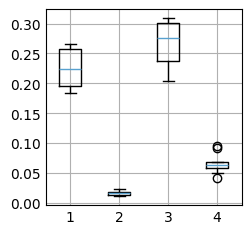

In [49]:
# sim_e4e
# sim_hybrid
# sim_e4e_edit 
# sim_hybrid_edit
# emo_score_e4e
# emo_score_hybrid

plt.boxplot([sim_e4e, sim_hybrid, sim_e4e_edit, sim_hybrid_edit])
plt.show()



In [30]:
T = [1, 2]
V = [2, 3]

for low, high in zip(["t", "v"], [T, V]):
    high.append(low)

T, V

([1, 2, 't'], [2, 3, 'v'])